In [1]:
import numpy as np
import torch
from hmc_u1 import HMC_U1
from field_transformations import manual_field_transformation
from nn_model_simple import NNFieldTransformation
from utils import plot_results, compute_autocorrelation

In [2]:
# Parameters
""" 
total_time = n_steps * step_size should be around 1 to 2 units.
If the energy conservation is not good, try to reduce the step size.
"""

lattice_size = 16
volume = lattice_size ** 2
beta = 3
n_thermalization_steps = 20000
n_steps = 10
step_size = 0.001
n_iterations = 5000

hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size)

### No Field Transformation

>>> No Field Transformation


Running HMC: 100%|██████████| 5000/5000 [00:02<00:00, 2087.33it/s]


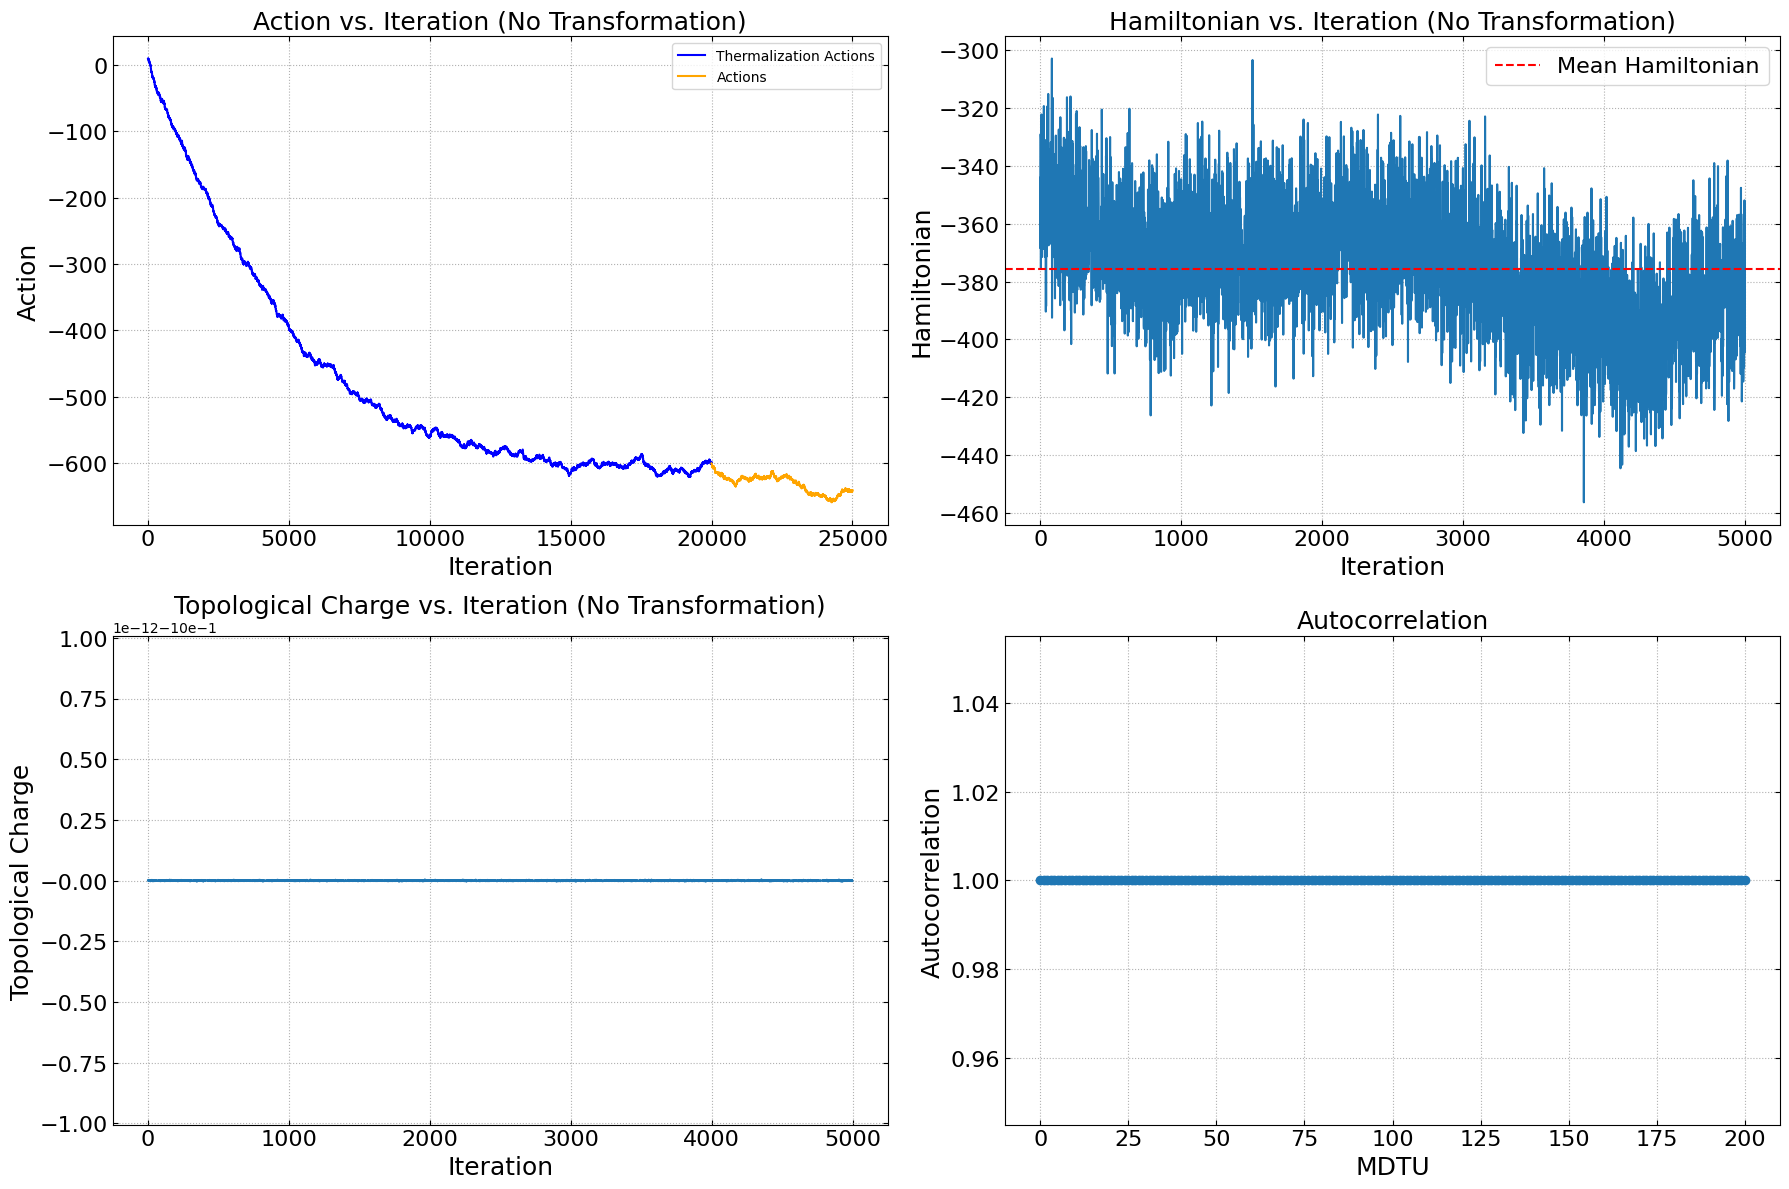

Thermalization acceptance rate: 0.7258
Acceptance rate: 0.7274
Relative variation of Hamiltonian (delta H / H_mean): -0.4087
Variation of topological charge (delta Q): 0.0000


In [3]:
print(">>> No Field Transformation")

# Thermalize the system
theta_thermalized, thermalization_actions, thermalization_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, actions, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

# Compute autocorrelation of the topological charge
max_lag = 200
autocorrelations = compute_autocorrelation(topological_charges, max_lag, beta, volume)

# Plot results
plot_results(thermalization_actions, actions, topological_charges, hamiltonians, autocorrelations, title_suffix="(No Transformation)")

# Print the acceptance rate
print(f"Thermalization acceptance rate: {thermalization_acceptance_rate:.4f}")
print(f"Acceptance rate: {acceptance_rate:.4f}")

# Calculate and print the variation of Hamiltonian (delta H) relative to mean H
delta_H = np.max(hamiltonians) - np.min(hamiltonians)
H_mean = np.mean(hamiltonians)
relative_delta_H = delta_H / H_mean
print(f"Relative variation of Hamiltonian (delta H / H_mean): {relative_delta_H:.4f}")

# Calculate and print the variation of topological charge (delta Q)
delta_Q = np.max(topological_charges) - np.min(topological_charges)
print(f"Variation of topological charge (delta Q): {delta_Q:.4f}")

### Neural Network Field Transformation

>>> Neural Network Field Transformation


Training Neural Network: 100%|██████████| 500/500 [00:00<00:00, 880.04it/s]


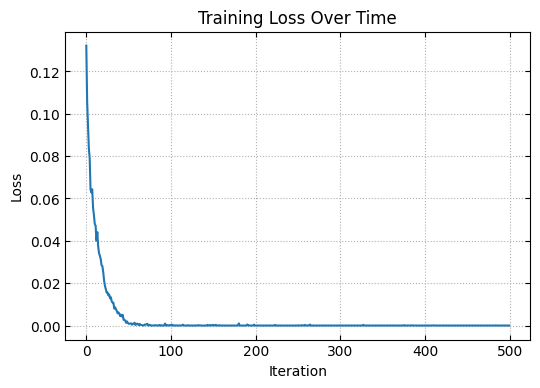

Running HMC: 100%|██████████| 5000/5000 [00:03<00:00, 1393.56it/s]


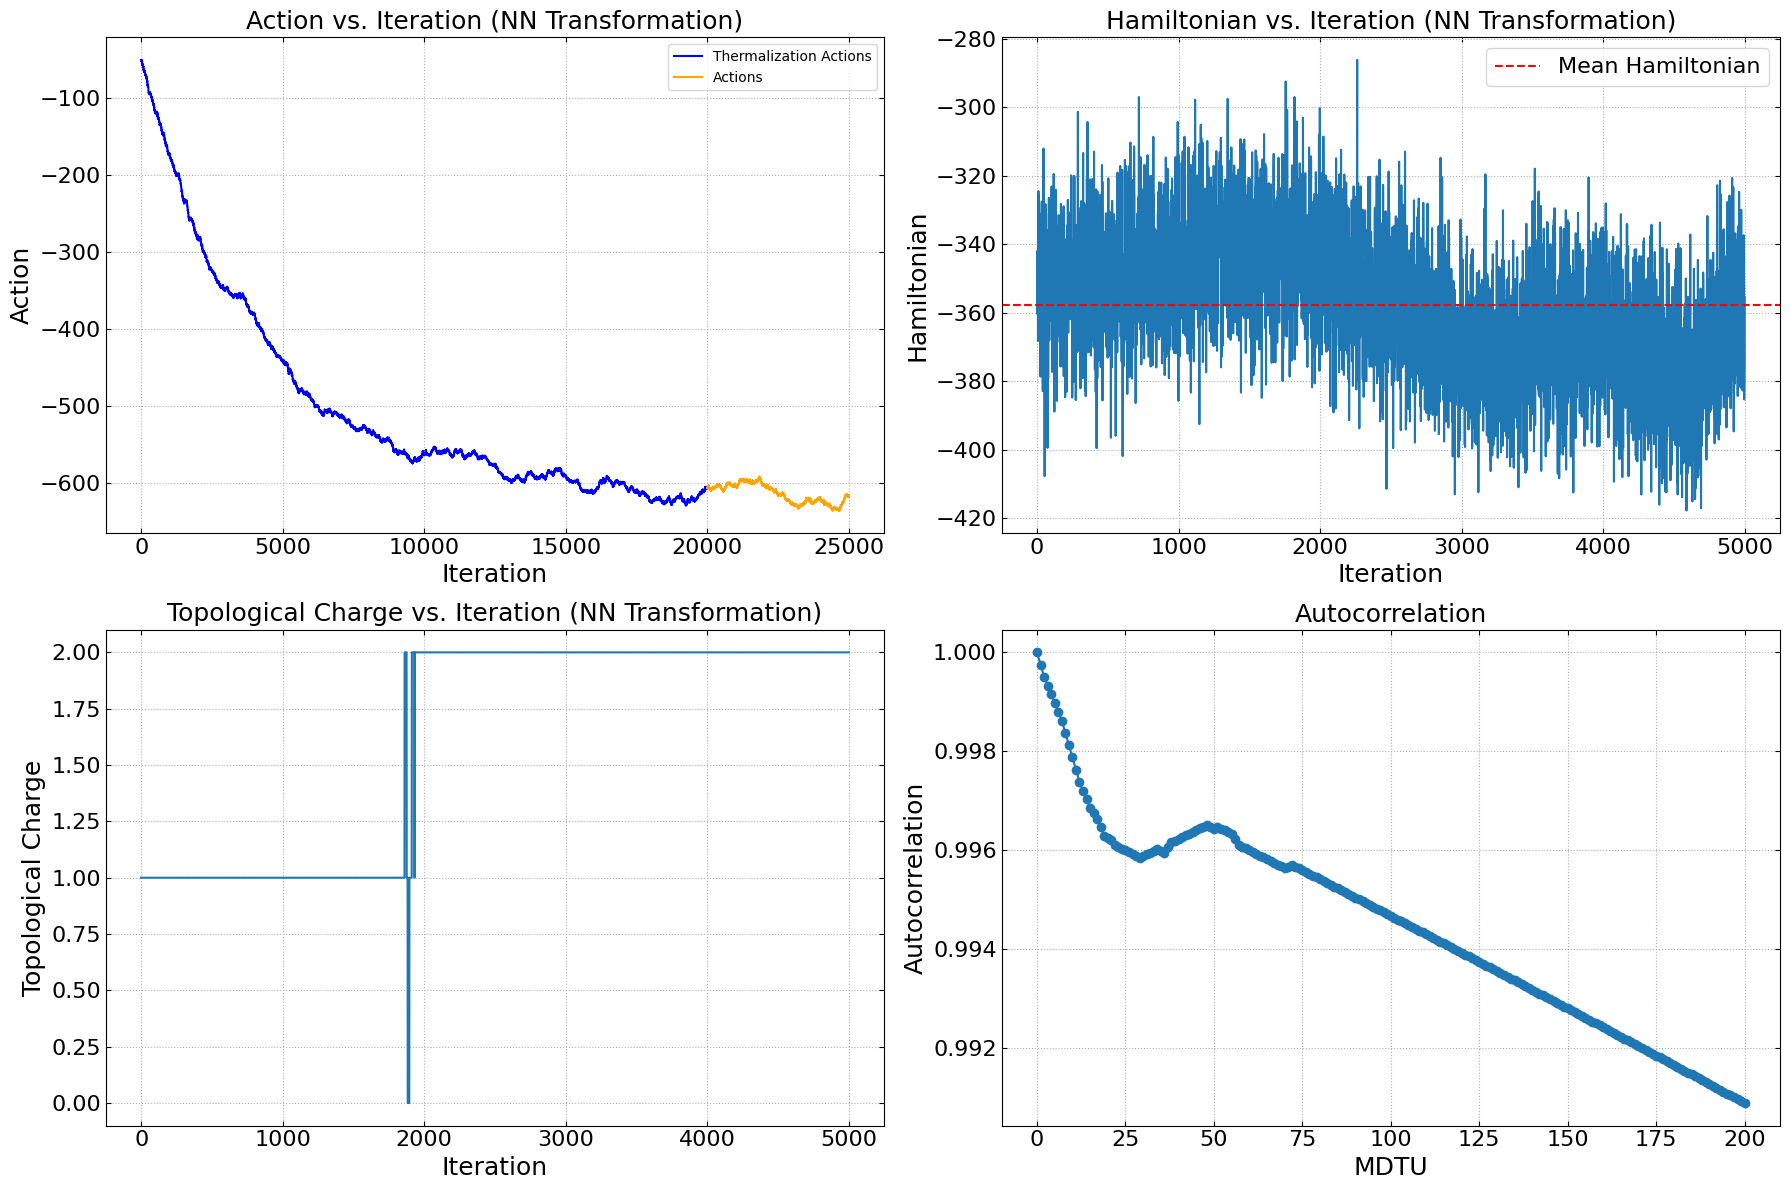

Thermalization acceptance rate: 0.7257
Acceptance rate: 0.7310
Relative variation of Hamiltonian (delta H / H_mean): -0.3678
Variation of topological charge (delta Q): 2.0000


In [5]:
print(">>> Neural Network Field Transformation")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, model_type='CNN')
nn_transformation.train(hmc, n_iterations=500)

# Thermalize the system
theta_thermalized, thermalization_actions, thermalization_acceptance_rate = hmc.thermalize(field_transformation=nn_transformation)

# check boundary elements are matched
assert np.all(np.roll(theta_thermalized[1], shift=-1, axis=0)[-1, :] == theta_thermalized[1][0, :])
assert np.all(np.roll(theta_thermalized[0], shift=-1, axis=1)[:, -1] == theta_thermalized[0][:, 0])

# Run HMC without field transformation
final_config, actions, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized, field_transformation=nn_transformation)

# Compute autocorrelation of the topological charge
max_lag = 200
autocorrelations = compute_autocorrelation(topological_charges, max_lag, beta, volume)

# Plot results
plot_results(thermalization_actions, actions, topological_charges, hamiltonians, autocorrelations, title_suffix="(NN Transformation)")

# Print the acceptance rate
print(f"Thermalization acceptance rate: {thermalization_acceptance_rate:.4f}")
print(f"Acceptance rate: {acceptance_rate:.4f}")

# Calculate and print the variation of Hamiltonian (delta H) relative to mean H
delta_H = np.max(hamiltonians) - np.min(hamiltonians)
H_mean = np.mean(hamiltonians)
relative_delta_H = delta_H / H_mean
print(f"Relative variation of Hamiltonian (delta H / H_mean): {relative_delta_H:.4f}")

# Calculate and print the variation of topological charge (delta Q)
delta_Q = np.max(topological_charges) - np.min(topological_charges)
print(f"Variation of topological charge (delta Q): {delta_Q:.4f}")

### Manual Field Transformation

In [5]:
print(">>> Manual Field Transformation")

# Thermalize the system
theta_thermalized, thermalization_actions, thermalization_acceptance_rate = hmc.thermalize(field_transformation=manual_field_transformation)

# Run HMC without field transformation
final_config, actions, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized, field_transformation=manual_field_transformation)

# Compute autocorrelation of the topological charge
max_lag = 200
autocorrelations = compute_autocorrelation(topological_charges, max_lag, beta, volume)

# Plot results
plot_results(thermalization_actions, actions, topological_charges, hamiltonians, autocorrelations, title_suffix="(Manual Transformation)")

# Print the acceptance rate
print(f"Thermalization acceptance rate: {thermalization_acceptance_rate:.4f}")
print(f"Acceptance rate: {acceptance_rate:.4f}")

# Calculate and print the variation of Hamiltonian (delta H) relative to mean H
delta_H = np.max(hamiltonians) - np.min(hamiltonians)
H_mean = np.mean(hamiltonians)
relative_delta_H = delta_H / H_mean
print(f"Relative variation of Hamiltonian (delta H / H_mean): {relative_delta_H:.4f}")

# Calculate and print the variation of topological charge (delta Q)
delta_Q = np.max(topological_charges) - np.min(topological_charges)
print(f"Variation of topological charge (delta Q): {delta_Q:.4f}")

>>> Manual Field Transformation


Thermalizing:  57%|█████▋    | 11416/20000 [00:05<00:04, 2065.17it/s]


KeyboardInterrupt: 